# Primary Model Pipeline

In [2]:
import collections
import pandas as pd
import numpy as np
import time
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [3]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [4]:
tf.__version__

'2.0.0'

### Load Datasets and Clean
In this configuration the relevant data set should be loaded from the same folder as the notebook

In [5]:
df = pd.read_csv('joined_data_89035_11-Oct-19_15_02_jackson_1.csv')

The data consists of timestamps from the two hardware devices and a diff between them. When the two hardware data streams were stitched together an effor was made to minimize this diff, but the driver configuration did not easily permit eliminating it. This information is included to understand the accuracy of the data, but will not be used during the training.

The time data is followed by the 8 channels from the Myo, this data will be used as input features.

This is followed by the 63 positional points from the Leap cameras. These will be used as labels.

In [6]:
df.head()

Leap timestamp  timestamp diff  emg timestamp   ch1   ch2   ch3   ch4  \
0    1.570825e+09        0.018883   1.570825e+09  26.0  26.0  33.0  39.0   
1    1.570825e+09       -0.009388   1.570825e+09  27.0  26.0  33.0  41.0   
2    1.570825e+09        0.003521   1.570825e+09  28.0  26.0  36.0  45.0   
3    1.570825e+09        0.008674   1.570825e+09  27.0  26.0  36.0  44.0   
4    1.570825e+09       -0.035640   1.570825e+09  26.0  25.0  36.0  45.0   

     ch5    ch6   ch7   ch8    Wrist x    Wrist y    Wrist z  \
0   76.0  122.0  73.0  40.0  14.345146 -28.880585  41.945660   
1  100.0  154.0  76.0  41.0  15.318302 -28.509491  41.854588   
2  109.0  162.0  74.0  36.0  15.901169 -28.448547  41.679031   
3  117.0  153.0  62.0  31.0  15.561348 -27.243500  42.602146   
4  117.0  146.0  55.0  30.0  14.022196 -25.875831  43.936406   

   Thumb Proximal x  Thumb Proximal y  Thumb Proximal z  Thumb Intermediate x  \
0        -14.511490        -31.244080         48.421452            -44.250854   
1        -13.438496        -31.833557         48.346691            -43.926510   
2        -12.779259        -32.222015         48.268463            -44.093941   
3        -13.170662        -31.661469         48.533466            -44.260918   
4        -14.704097        -32.160936         47.746317            -43.907513   

   Thumb Intermediate y  Thumb Intermediate z  Thumb Distal x  Thumb Distal y  \
0            -21.617554             11.630253      -56.655487      -19.513519   
1            -22.808380             12.019588      -57.077389      -20.678085   
2            -22.941345             12.716362      -58.372322      -20.254303   
3            -23.374695             12.541550      -58.659309      -21.077148   
4            -25.013377              9.996756      -57.398566      -22.772437   

   Thumb Distal z  Thumb Tip x  Thumb Tip y  Thumb Tip z  Index Proximal x  \
0      -18.850239   -59.476807   -20.989502   -41.259689        -23.829559   
1      -18.143740   -60.525982   -21.874222   -40.480637        -24.551014   
2      -16.885494   -63.152214   -20.763000   -39.003716        -24.906563   
3      -17.034952   -64.274513   -21.420837   -38.959213        -25.174019   
4      -20.003330   -64.414212   -22.118178   -41.459390        -25.482445   

   Index Proximal y  Index Proximal z  Index Intermediate x  \
0         22.190704        -10.724735            -38.847610   
1         21.427505        -10.644770            -38.971554   
2         21.106598        -10.462788            -39.117287   
3         20.237213        -11.490047            -38.117607   
4         18.433143        -13.571548            -34.666684   

   Index Intermediate y  Index Intermediate z  Index Distal x  Index Distal y  \
0             12.789703            -48.308399      -46.399170       -8.929413   
1             12.806976            -48.645580      -45.855907       -9.104858   
2             13.302673            -48.719894      -45.816750       -8.568634   
3             11.622986            -50.021996      -44.151466      -10.463135   
4             10.130046            -53.206259      -39.042566      -11.996423   

   Index Distal z  Index Tip x  Index Tip y  Index Tip z  Middle Proximal x  \
0      -52.515270   -48.332855   -23.789734   -45.552608          -3.701782   
1      -52.989914   -47.223698   -23.898071   -45.756250          -4.303158   
2      -53.537201   -47.039330   -23.465637   -46.492203          -4.631828   
3      -54.737976   -45.200645   -25.284698   -47.508385          -4.672478   
4      -59.289892   -39.887228   -27.167942   -52.809481          -4.501912   

   Middle Proximal y  Middle Proximal z  Middle Intermediate x  \
0          18.001740         -16.674385             -23.853134   
1          17.915894         -16.621838             -24.265499   
2          17.917450         -16.532169             -24.484550   
3          17.480835         -16.982073             -23.160393   
4          17.018609         -17.476518        

In [7]:
df = df.drop(labels=["Leap timestamp", "timestamp diff", "emg timestamp"], axis=1)

In [8]:
df.describe()

ch1           ch2           ch3           ch4           ch5  \
count  89035.000000  89035.000000  89035.000000  89035.000000  89035.000000   
mean     103.236289     54.813264     33.531679     49.346875    321.834380   
std      122.991689     67.208425     12.972133     18.917846    164.497039   
min       14.000000     16.000000     16.000000     14.000000     16.000000   
25%       33.000000     25.000000     27.000000     37.000000    202.000000   
50%       70.000000     29.000000     31.000000     46.000000    299.000000   
75%      115.000000     50.000000     36.000000     57.000000    419.000000   
max     1539.000000   1041.000000    409.000000    339.000000   1310.000000   

                ch6           ch7           ch8       Wrist x       Wrist y  \
count  89035.000000  89035.000000  89035.000000  89035.000000  89035.000000   
mean     243.814298     92.025226     96.994047     15.516873      1.674711   
std      110.474193    101.262445     97.165795      5.495505      9.780762   
min       15.000000     14.000000     14.000000    -21.595345    -31.174500   
25%      169.000000     52.000000     37.000000     12.170715     -5.288666   
50%      230.000000     71.000000     65.000000     15.575600      0.918304   
75%      305.000000     97.000000    127.000000     18.965968      7.987320   
max      994.000000   1446.000000   1305.000000     37.484314     41.310349   

            Wrist z  Thumb Proximal x  Thumb Proximal y  Thumb Proximal z  \
count  89035.000000      89035.000000      89035.000000      89035.000000   
mean      50.092818         -9.643305        -12.168692         56.587906   
std        2.430574          6.737839         11.891495          2.991407   
min       29.856903        -44.104740        -49.775757         32.424816   
25%       48.890802        -13.957508        -20.710114         55.037601   
50%       50.402223         -9.675439        -13.160014         57.209934   
75%       51.733793         -5.324154         -4.639065         58.697407   
max       54.705269         15.363602         37.174438         61.444584   

       Thumb Intermediate x  Thumb Intermediate y  Thumb Intermediate z  \
count          89035.000000          89035.000000          89035.000000   
mean             -38.220023            -22.720576             22.119360   
std                9.189228             10.919354              6.366507   
min              -59.871008            -52.597229             -9.114346   
25%              -45.156399            -30.485149             18.264471   
50%              -40.350983            -22.994125             22.258654   
75%              -31.388649            -15.540815             26.383771   
max                1.499582             41.964020             50.866493   

       Thumb Distal x  Thumb Distal y  Thumb Distal z   Thumb Tip x  \
count    89035.000000    89035.000000    89035.000000  89035.000000   
mean       -52.839431      -30.729727       -3.494677    -67.126555   
std         17.424229       16.900053        9.885429     25.317285   
min        -90.959778      -70.534225      -40.951813   -110.831558   
25%        -66.346355      -45.493643       -9.884459    -86.928444   
50%        -57.777733      -31.301544       -3.833950    -76.524074   
75%        -39.401667      -18.036278        2.685818    -46.352702   
max          3.814606       66.682129       46.175575     14.950737   

        Thumb Tip y   Thumb Tip z  Index Proximal x  Index Proximal y  \
count  89035.000000  89035.000000      89035.000000      89035.000000   
mean     -34.061263    -15.944810        -27.898627          0.492399   
std       22.963820     14.040474          2.250165          5.372042   
min      -86.958206    -63.914200        -34.620964        -19.794815   
25%      -54.925632    -25.138304        -29.389551         -3.109421   
50%      -33.323090    -16.321307        -28.075296          0.524719   
75%      -16.301476     -6.829496        -26.670048          4.017509  

## Autoencoder
The final pipeline will pass the data into an LSTM and then into an autoencoder to expand features into the 63 point space. This autoencoder will be trained first below:

In [9]:
feature_ar = df.loc[:, 'ch1':'ch8'].values
label_ar = df.loc[:, 'Wrist x':].values

In [10]:
feature_ar.shape

(89035, 8)

In [11]:
label_ar.shape

(89035, 63)

Build the autoencoder structure:

In [12]:
encoding_dim = 9 #dimensionality of 'feature' vector

a_fn = None

# Full autoencoder
input_vec = Input(shape=(63,))
dense_0 = Dense(32, activation=a_fn)(input_vec)
dense_1 = Dense(16, activation=a_fn)(dense_0)
encoded = Dense(encoding_dim, activation=a_fn)(dense_1)
dense_2 = Dense(32, activation=a_fn, name='decoder_0')(encoded)
dense_3 = Dense(16, activation=a_fn, name='decoder_1')(dense_2)
decoded = Dense(63, activation=a_fn, name='decoder_output')(dense_3)

autoencoder = Model(input_vec, decoded)

# Encoder from autoencoder
encoder = Model(input_vec, encoded)

# Decoder from autoencoder layers
decoder_input = Input(shape=(encoding_dim,), name='encoded_input')
decode_0 = autoencoder.layers[-3](decoder_input)
decode_1 = autoencoder.layers[-2](decode_0)
decode_output = autoencoder.layers[-1](decode_1)
decoder = Model(decoder_input, decode_output, name='decoder')

# Train Autoencoder
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 63)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                2048      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 153       
_________________________________________________________________
decoder_0 (Dense)            (None, 32)                320       
_________________________________________________________________
decoder_1 (Dense)            (None, 16)                528       
_________________________________________________________________
decoder_output (Dense)       (None, 63)                1071  

In [13]:
autoencoder.evaluate(label_ar, label_ar)

89035/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

2404.2334353184056

From the above evaluation the initial untrained loss is around 2500.
Now train the model:

In [14]:
ret = autoencoder.fit(label_ar, label_ar, batch_size=512, epochs=25, verbose=1, validation_split=0.2)

Train on 71228 samples, validate on 17807 samples
Epoch 1/25
71228/71228 [==============================] - 1s 17us/sample - loss: 538.2254 - val_loss: 143.9613
Epoch 2/25
71228/71228 [==============================] - 0s 5us/sample - loss: 105.4004 - val_loss: 85.7478
Epoch 3/25
71228/71228 [==============================] - 0s 5us/sample - loss: 69.2755 - val_loss: 57.0612
Epoch 4/25
71228/71228 [==============================] - 0s 5us/sample - loss: 48.1949 - val_loss: 41.3859
Epoch 5/25
71228/71228 [==============================] - 0s 6us/sample - loss: 37.2274 - val_loss: 32.6360
Epoch 6/25
71228/71228 [==============================] - 0s 6us/sample - loss: 29.8606 - val_loss: 26.7402
Epoch 7/25
71228/71228 [==============================] - 0s 6us/sample - loss: 24.5669 - val_loss: 22.4840
Epoch 8/25
71228/71228 [==============================] - 0s 6us/sample - loss: 20.9963 - val_loss: 19.4678
Epoch 9/25
71228/71228 [==============================] - 0s 6us/sample - loss: 18

Now the encoder - decoder pair will be tested seperately for loss:

In [15]:
encoded_vec = encoder.predict(label_ar)
decoded_vec = decoder.predict(encoded_vec)

#compilation is only to enable evaluation
decoder.compile(optimizer='adam', loss='mse')
decoder.evaluate(encoded_vec, label_ar)

89035/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

10.06715932164728

In [16]:
print(encoded_vec.shape)
print(decoded_vec.shape)

(89035, 9)
(89035, 63)


## LSTM
Here the lstm will be trained. The 8 channels of sEMG data will be processed by the LSTM, which will return a vector of 9 complex features. These will then be processed by the autoencoder, trained in the previous section, to create the 63 hand coordinates.

To train the sequential recurrent LSTM the data will be grouped into 'sequences' of 24 steps in time. The LSTM will be trained with many sequence groups.

In [17]:
seq_length = 32

def overlap_samples(seq_length, feats, labels):
    new_l = labels[seq_length - 1:]
    feat_list = [feats[i:i + seq_length] for i in range(feats.shape[0] - seq_length + 1)]
    new_f = np.array(feat_list)
    return new_f, new_l

features, labels = overlap_samples(seq_length, feature_ar, label_ar)
print(features.shape)
print(labels.shape)

(89004, 32, 8)
(89004, 63)


In [17]:
#lstm layers
inputs = Input(shape=(None, 8), name="inputs")
lstm_0 = LSTM(64, return_sequences=True, name="lstm_0")(inputs)
do = Dropout(0.2)(lstm_0)
lstm_1 = LSTM(64, return_sequences=False, name="lstm_1")(do)
lstm_out = Dense(9, activation=None, name="lstm_out")(lstm_1)

#decoder layers
decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
decoder_0.trainable = False
decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
decoder_1.trainable = False
decoder_output = decoder.get_layer("decoder_output")(decoder_1)
decoder_output.trainable = False

model = Model(inputs, decoder_output, name="model_v1")
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "model_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, 8)]         0         
_________________________________________________________________
lstm_0 (LSTM)                (None, None, 64)          18688     
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
lstm_out (Dense)             (None, 9)                 585       
_________________________________________________________________
decoder_0 (Dense)            (None, 32)                320       
_________________________________________________________________
decoder_1 (Dense)            (None, 16)                528

In [18]:
model.evaluate(features, labels, verbose=1)

89004/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

1934.8559765177338

In [19]:
history = model.fit(features, labels, batch_size=seq_length, epochs=4, verbose=1, validation_split=0.2)

Train on 71203 samples, validate on 17801 samples
Epoch 1/4
71203/71203 [==============================] - 81s 1ms/sample - loss: 216.5221 - val_loss: 162.9093
Epoch 2/4
71203/71203 [==============================] - 77s 1ms/sample - loss: 150.5939 - val_loss: 148.9668
Epoch 3/4
71203/71203 [==============================] - 76s 1ms/sample - loss: 133.9150 - val_loss: 151.6409
Epoch 4/4
71203/71203 [==============================] - 78s 1ms/sample - loss: 117.3356 - val_loss: 142.3549


In [20]:
model.save('AE_model.h5')

### Visualize Model Error

Plot the validation loss over the training epochs:

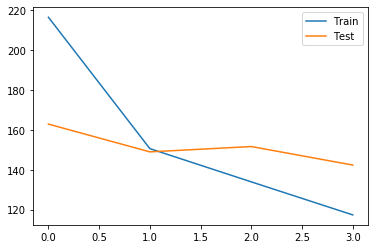

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])

Plotting the errors for each field below shows that the 'y' coordinates for each figure generally have the largest error and the errors growing rapidly approaching the tips of the fingers.

In [24]:
preds = model.predict(features)

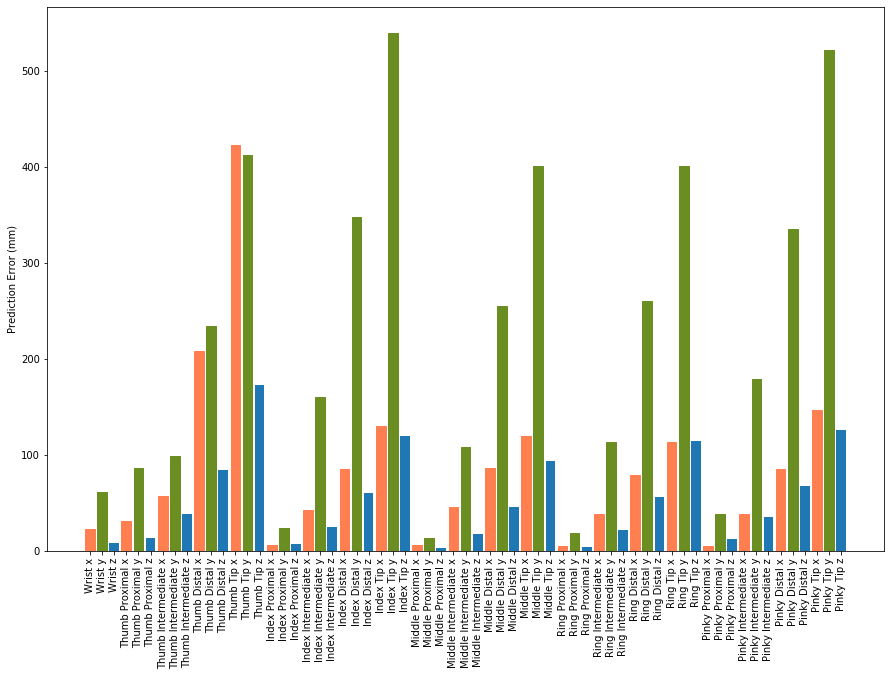

In [25]:
error = labels - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:], avg_error)
for i in range(0,63,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

## LSTM with Fully Connected Layers
Below is a test using a model with several dense layers after the LSTM layers, instead of using the pretrained autoencoder.

In [26]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.2))
model_fc.add(LSTM(64))
model_fc.add(BatchNormalization())
model_fc.add(Dense(100, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.2))
model_fc.add(Dense(64, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(63, input_dim=64))

model_fc.compile(optimizer='Adam', loss='mse')

history = model_fc.fit(features, labels, batch_size=seq_length, epochs=5, verbose=1, validation_split=0.2)

Train on 71203 samples, validate on 17801 samples
Epoch 1/5
71203/71203 [==============================] - 85s 1ms/sample - loss: 288.2572 - val_loss: 172.3445
Epoch 2/5
71203/71203 [==============================] - 79s 1ms/sample - loss: 165.3639 - val_loss: 160.7494
Epoch 3/5
71203/71203 [==============================] - 75s 1ms/sample - loss: 146.0014 - val_loss: 155.3123
Epoch 4/5
71203/71203 [==============================] - 78s 1ms/sample - loss: 136.2262 - val_loss: 142.0346
Epoch 5/5
71203/71203 [==============================] - 78s 1ms/sample - loss: 130.6295 - val_loss: 145.3026


In [27]:
model_fc.save('FC_model.h5')

### Visual Model Error

In [28]:
preds = model_fc.predict(features)

In [35]:
error = labels - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:], avg_error)
for i in range(0,63,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

ValueError: operands could not be broadcast together with shapes (89004,63) (89004,18) 

## Training the Model On Tips Only
In an attempt to improve the accuracy of prediction of the fingertips the above models are modified and trained only using the fingertip position data to understand if this simplification yields an improvement

In [27]:
labels_tip = labels[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
labels_tip.shape

(89004, 18)

In [28]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.2))
model_fc.add(LSTM(64))
model_fc.add(BatchNormalization())
model_fc.add(Dense(100, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.2))
model_fc.add(Dense(64, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(18, input_dim=64))

model_fc.compile(optimizer='Adam', loss='mse')

history = model_fc.fit(features, labels_tip, batch_size=seq_length, epochs=5, verbose=1, validation_split=0.2)

Train on 71203 samples, validate on 17801 samples
Epoch 1/5
71203/71203 [==============================] - 85s 1ms/sample - loss: 547.3261 - val_loss: 334.5111
Epoch 2/5
71203/71203 [==============================] - 77s 1ms/sample - loss: 335.3348 - val_loss: 322.1098
Epoch 3/5
71203/71203 [==============================] - 78s 1ms/sample - loss: 295.1551 - val_loss: 287.6545
Epoch 4/5
71203/71203 [==============================] - 78s 1ms/sample - loss: 261.2659 - val_loss: 284.4439
Epoch 5/5
71203/71203 [==============================] - 77s 1ms/sample - loss: 244.5969 - val_loss: 254.6947


In [29]:
history = model_fc.fit(features, labels_tip, batch_size=seq_length, epochs=5, verbose=1, validation_split=0.2)

Train on 71203 samples, validate on 17801 samples
Epoch 1/5
71203/71203 [==============================] - 78s 1ms/sample - loss: 232.6070 - val_loss: 251.5207
Epoch 2/5
71203/71203 [==============================] - 79s 1ms/sample - loss: 222.2351 - val_loss: 270.7736
Epoch 3/5
71203/71203 [==============================] - 77s 1ms/sample - loss: 212.7023 - val_loss: 246.4242
Epoch 4/5
71203/71203 [==============================] - 77s 1ms/sample - loss: 203.8269 - val_loss: 243.0659
Epoch 5/5
71203/71203 [==============================] - 77s 1ms/sample - loss: 196.9364 - val_loss: 250.3578


### Visual Model Error
A similar visualizion is now done on this new more restricted model. These errors show 20% - 25% improvement on fingertip y position.

In [30]:
preds = model_fc.predict(features)

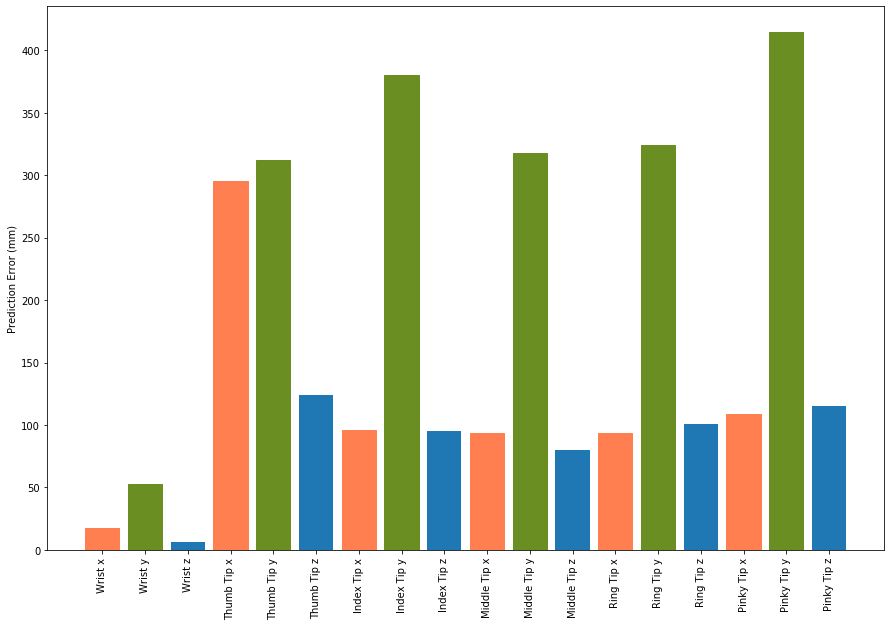

In [39]:
error = labels_tip - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:][[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]], avg_error)
for i in range(0,18,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()